# Introducing molecular dynamics

This hands-on workshop introduces the basic concepts of HOOMD-blue and will teach you how to run a molecular dynamics simulation. For more details, information that may be helpful when completing the exercises, see the [HOOMD-blue documentation](https://hoomd-blue.readthedocs.io/).

**Google Colab users:** Click the "Copy to Drive" button in the toolbar to save this notebook and any edits that you make to your Google Drive.

## Utility code

Please ignore the content of these cells, they provide some helpful methods but are not part of the workshop.

Run them one at a time, then click the arrow by "Utility code" to hide them.



In [8]:
# This cell installs HOOMD-blue in Google Colab.
try:
    import google

    !pip install -q condacolab
    import condacolab

    condacolab.install_from_url(
        'https://github.com/glotzerlab/hoomd-workshop/releases/download/2023.1.0/hoomd-workshop-2023.1.0-Linux-x86_64.sh'
    )
except ModuleNotFoundError:
    pass

In [9]:
import gsd.hoomd
import hoomd
import IPython
import packaging.version
import PIL
import matplotlib
import matplotlib.pyplot as plt
import numpy
import math
import warnings
import fresnel
import itertools 
import io 
import freud 
import io
import warnings


device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=400, h=400)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    Lx = snapshot.configuration.box[0]
    Ly = snapshot.configuration.box[1]
    Lz = snapshot.configuration.box[2]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04

    if (hasattr(snapshot, 'log')
            and 'particles/md/pair/LJ/energies' in snapshot.log):
        energies = snapshot.log['particles/md/pair/LJ/energies']
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=numpy.min(energies),
                                             vmax=numpy.max(energies),
                                             clip=True),
            cmap=matplotlib.colormaps['viridis'])
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))
        geometry.material.primitive_color_mix = 1
    
    else:
        
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=-0.5,
                                              vmax=1,
                                              clip=True),
            cmap=matplotlib.colormaps['RdYlBu'])
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(snapshot.particles.typeid))
        geometry.material.primitive_color_mix = 1

    box = fresnel.geometry.Box(scene, [Lx, Ly, Lz, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(Lx * 2, Ly, Lz * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=Lx * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=20)

def render_image(snapshot):
  a = render(snapshot)
  return IPython.display.Image(a._repr_png_())

def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert("P")
       # "P", palette=PIL.Image.Palette.ADAPTIVE)
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f)
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if (size > 3000):
        warnings.warn(f"Large GIF: {size} KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))
 
warnings.filterwarnings('ignore', module='hoomd')
warnings.filterwarnings('ignore', module='numpy')

# Introducing Polymers/Bonds

In this section, we are going to extend the tutorial to a system with bonds, i.e., a polymer. 

Here, we manually set the 10 particle positions to be in a straight line in $z$ direction:

In [10]:
snapshot = gsd.hoomd.Snapshot()

# Place a polymer in the box.
snapshot.particles.N = 10
snapshot.particles.position = [[-4, 0, 0],[-3, 0, 0],[-2, 0, 0], 
                               [-1, 0, 0], [0, 0, 0], [1, 0, 0],
                               [2, 0, 0],[3, 0, 0],[4, 0, 0],[5,0,0]]
snapshot.particles.types = ['A']
snapshot.particles.typeid = [0] * 10
snapshot.configuration.box = [20, 20, 20, 0, 0, 0]

/opt/miniconda3/envs/hoomd-workshop/lib/python3.11/site-packages/gsd/hoomd.py:420: FutureWarning: Snapshot is deprecated, use Frame
  warnings.warn("Snapshot is deprecated, use Frame", FutureWarning)


Now we need to add bonds. See [Hoomd-blue Documentation](https://hoomd-blue.readthedocs.io/en/latest/module-md-bond.html#md-bond) for available bond potentials.


In [11]:
# Connect particles with bonds.
snapshot.bonds.N = 9
snapshot.bonds.types = ['A-A']
snapshot.bonds.typeid = [0] * 9

Add a ``snapshot.bonds.group`` array that contains the bonds:

In [ ]:
# add code 

Save and render initial configuration (bonds not shown):

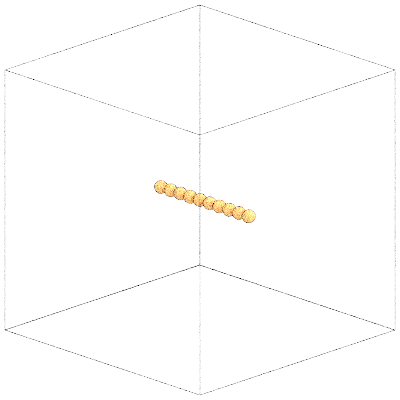

In [12]:
with gsd.hoomd.open(name='molecular_init.gsd', mode='wb') as f:
    f.append(snapshot)
render(snapshot)

We define [LJ pair](https://hoomd-blue.readthedocs.io/en/latest/module-md-pair.html#hoomd.md.pair.LJ) interactions that are cut at $2^{1/6}$, i.e., Weeks-Chandler-Andersen potential:

In [ ]:
cell = hoomd.md.nlist.Cell(buffer=0.4)
wca = hoomd.md.pair.LJ(nlist=cell)
wca.params[('A', 'A')] = dict(epsilon=1, sigma=1)
wca.r_cut[('A', 'A')] = 2**(1/6.)

THen we add [harmonic bond](https://hoomd-blue.readthedocs.io/en/latest/module-md-bond.html#hoomd.md.bond.Harmonic) interactions:

In [13]:
# Add code for bond interactions

Define simulation (`hoomd.Simulation`), integrator (`hoomd.md.Integrator` with `hoomd.md.methods.NVT` and all forces (`lj` and `harmonic`), and gsd writer (`hoomd.write.GSD`): 

In [14]:
sim = hoomd.Simulation(device=hoomd.device.CPU(), seed=1)
sim.create_state_from_gsd(filename='molecular_init.gsd')
nvt = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=1.5,tau=0.5)
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)
integrator = hoomd.md.Integrator(dt=0.005,
                                 methods=[nvt],
                                 forces=[harmonic,wca])
gsd_writer = hoomd.write.GSD(filename='molecular_trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(int(1e5)),
                             mode='wb')
sim.operations.integrator = integrator
sim.operations.writers.append(gsd_writer)

Run simulation for a million timesteps: 

In [15]:
sim.run(1e6)

Render movie (bonds not shown):

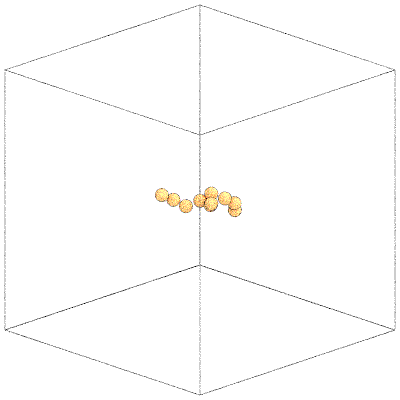

In [16]:
with gsd.hoomd.open('molecular_trajectory.gsd', 'rb') as trajectory:
    image = render_movie(trajectory)
image

In [17]:
del sim
del gsd_writer
del integrator, nvt, harmonic, wca, cell